In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from pylab import *

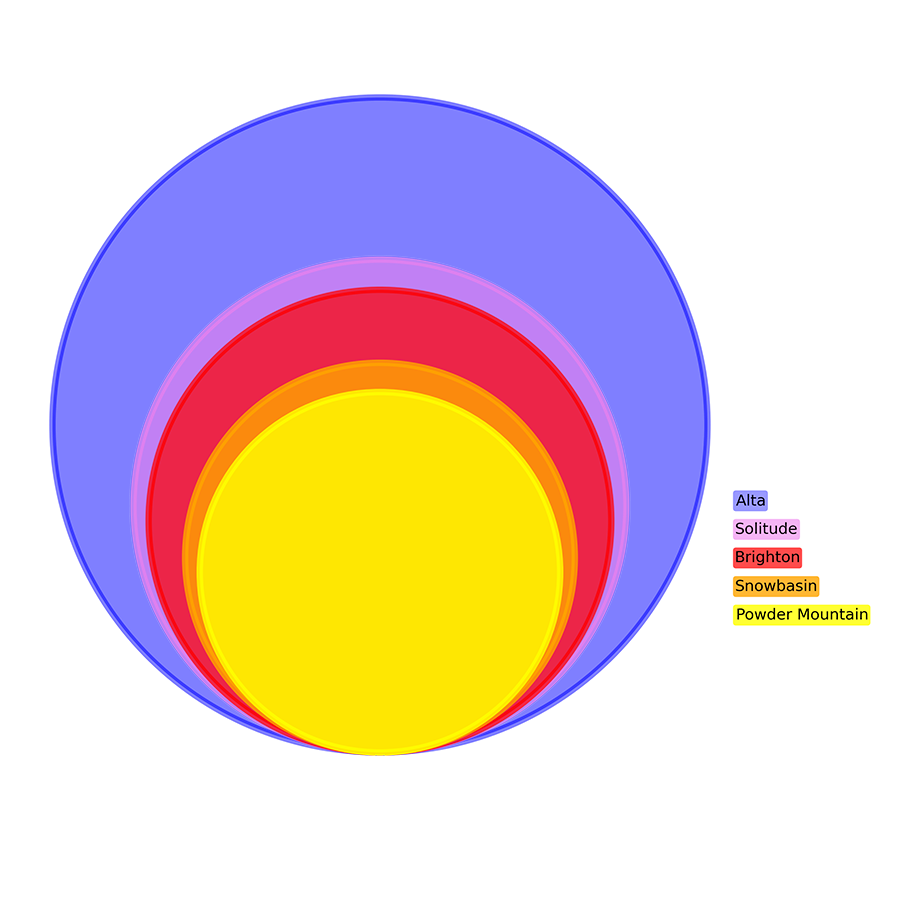

In [18]:
from IPython.display import Image
Image(filename='images/Snowbird.png', width=600, height=600)

#Visualizing a recommendation system:
This notebook walks through the process to create an image like the following to represent the similarity of two ski resorts based on previous customer purchase history:
__________________
### Load the data
Data consists of purchase history by user/resort - from this, we can create a large sparse matrix to calculate the similarity between two items. 

In [3]:
cols = ['resort','email','orders']
all_purch = pd.read_csv("data/raw_data_eos.csv", names = cols, skiprows= 1)

In [4]:
df_wide = pd.pivot_table(all_purch, values=["orders"],
        index=["resort", "email"],
        aggfunc=np.mean).unstack()
df_wide = df_wide.fillna(0)

### Calculating similarities 
Lots of methods to calculate distance - but for this we chose cosine similarity since it seems to provide thos best results when spot checked by humans

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
dists = cosine_similarity(df_wide)
dists = pd.DataFrame(dists, columns=df_wide.index)
dists.index = dists.columns

### Creat a function to return the most similar resorts

In [6]:
def get_similar(resort_inputs, n=None):
    """
    calculates which resorts are most similar to the resorts provided. Does not return
    the resorts that were provided
    
    Parameters
    ----------
    resorts: list a few resorts but ensure they match liftopia names
    
    Returns
    -------
    ranked_resorts: list
        rank ordered resorts
    """
    resorts_summed = dists[resort_inputs].apply(lambda row: np.sum(row), axis=1)
    resorts_summed = resorts_summed.order(ascending=False)
    ranked_resorts = resorts_summed.index[(resorts_summed.index.isin(resort_inputs)==False) & 
                                          (resorts_summed.index.isin(live_partners.Partner)==True)]
    ranked_resorts = ranked_resorts.tolist()
    if n is None:
        return ranked_resorts
       
    else:
        return ranked_resorts[:n]

In [12]:
#Filter for only partners who actually have inventory for sale right now
live_partners = pd.read_csv('data/live_partners_eos2.csv',names = ['Partner','Status'])
#lets test it....
get_similar(['Snowbird'],7)

['Alta',
 'Solitude',
 'Brighton',
 'Snowbasin',
 'Powder Mountain',
 'The Mountain Collective',
 'Deer Valley']

## Several more functions to build some circles to visualize the data

In [13]:
def circles(x, y, s, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data scale (ie. in data unit)
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array of
        values to be colormapped.  `c` can be a 2-D array in which the
        rows are RGB or RGBA, however.
    ax : Axes object, optional, default: None
        Parent axes of the plot. It uses gca() if not specified.
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.  (Note if you pass a `norm` instance, your
        settings for `vmin` and `vmax` will be ignored.)

    """
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    import pylab as plt
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    if isinstance(x, (int, long, float)):
        patches = [Circle((x, y), s),]
    elif isinstance(s, (int, long, float)):
        patches = [Circle((x_,y_), s) for x_,y_ in zip(x,y)]
    else:
        patches = [Circle((x_,y_), s_) for x_,y_,s_ in zip(x,y,s)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    return collection

###Now we need a way to get the similar resorts, plot them and save the image to file

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


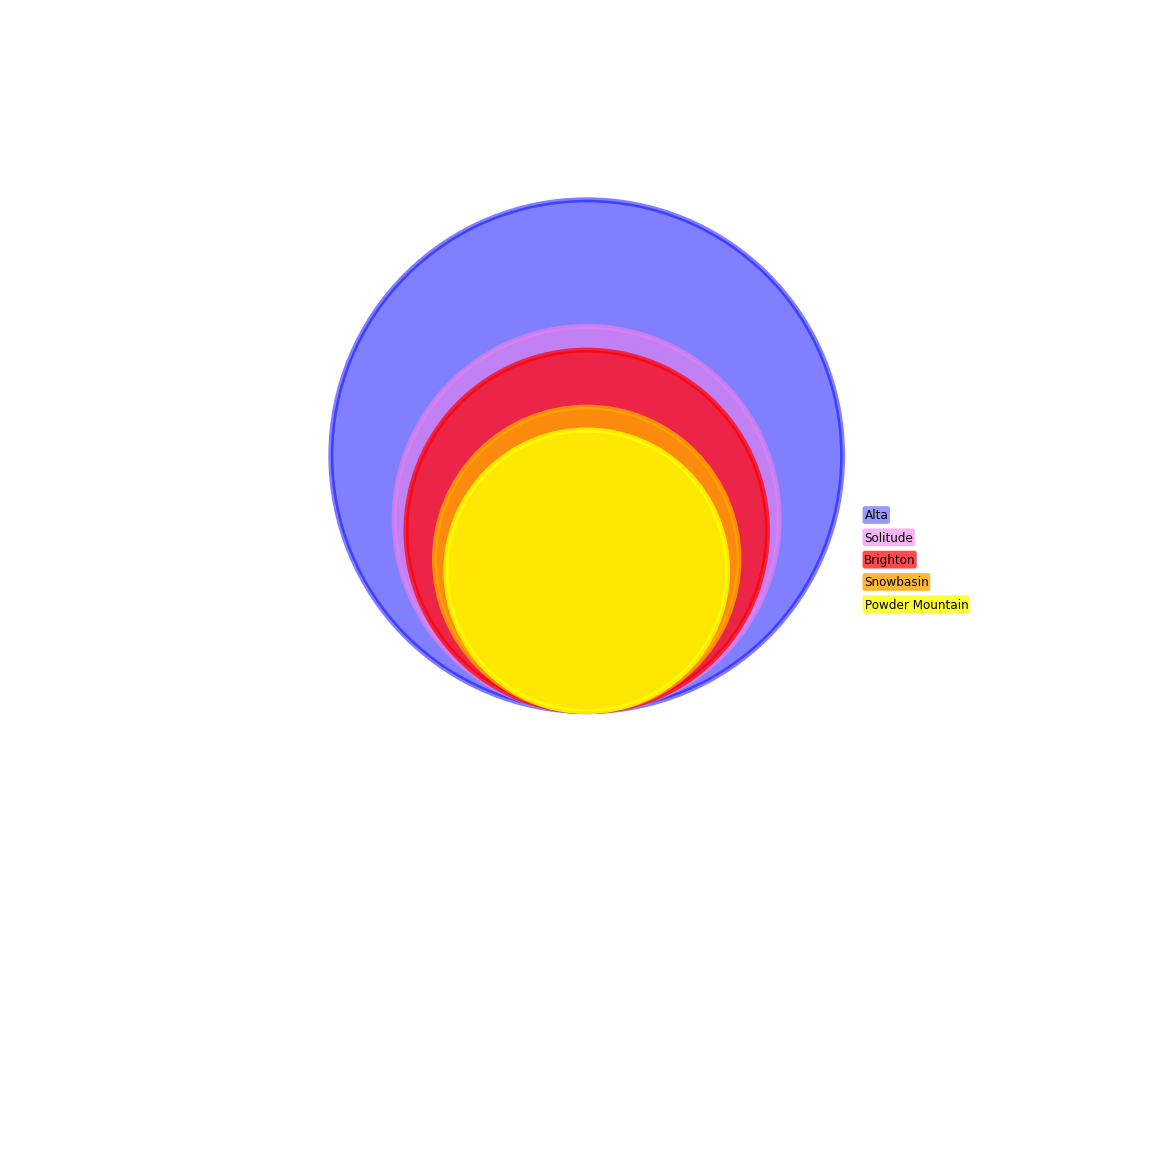

In [14]:

for i in xrange(0,1):
    choice = ['Snowbird']
    live_partners = pd.read_csv('data/live_partners_eos2.csv',names = ['Partner','Status'])
    partner_list = live_partners.dropna()
    partner_list = partner_list[partner_list.Partner.isin(choice)]
    values = partner_list.Partner.values

    recs = []
    for val in values:
        list1 = []
        partner = val
        list1.append(partner)
        if partner in ['Hidden Valley Highlands Ski Area','Rabbit Hill','White Pass Ski Resort','nan']:
            recommended = ['','','','','']
        else:
            recommended = get_similar(list1,5)

        list1 += recommended
        recs.append(list1) 

    columns = ['Partner','Rec1','Rec2','Rec3', 'Rec4', 'Rec5']
    result = pd.DataFrame(recs, columns = columns)
    df = result.T
    resorts_summed = dists[choice].apply(lambda row: np.sum(row), axis=1).order(ascending=False)
    df['similarity'] =  resorts_summed[0:6].values   

    # Make sure not too much overlap 
    import math
    similarity = df.similarity.values
    r= []
    #Create a list of radii from the values
    for i in xrange(0,len(similarity)):
        radius = math.sqrt(similarity[i]/math.pi)
        r.append(radius)

    
    for i in range(len(r)-1,1,-1):
        if (r[i]*1!=0) & (r[i-1]*1!=0):
            while r[i-1]-r[i] <0.01:
                  r[i-1]=r[i-1]*1.005



    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 12}

    matplotlib.rc('font', **font)


    figure(figsize=(20,20))
    ax=subplot(aspect='equal')

    x = .5
    y = .5

    c1,c2,c3,c4,c5,c6 = ['green','blue','violet','red','orange','yellow']
    a1,a2,a3,a4,a5,a6 = [.4,.5,.6,.7,.8,.8]

    #One circle for the Partner
    #circle1 = circles(x, y+r[0]-r[5], r[0], c1, alpha=a1, lw=5, edgecolor=c1)
    #One circle for the 5 recs
    circles(x, y+r[1]-r[5], r[1], c2, alpha=a2, lw=5, edgecolor=c2)
    circles(x, y+r[2]-r[5], r[2], c3, alpha=a3, lw=5, edgecolor=c3)
    circles(x, y+r[3]-r[5],r[3], c4, alpha=a4, lw=5, edgecolor=c4)
    circles(x, y+r[4]-r[5], r[4], c5, alpha=a5, lw=5, edgecolor=c5)
    circles(x, y, r[5], c6, alpha=a6, lw=5, edgecolor=c6)

    label_x = x+r[1]+.02
    label_y = y+.07

    #partner annotation
    # plt.annotate(result.ix[0].Partner, xy = (label_x, label_y), ha = 'left', va = 'center',
    #     bbox = dict(boxstyle = 'round,pad=.2', fc = c1, ec = 'none', alpha = a1))

    #Annotation for each reccomendation
    plt.annotate(result.ix[0].Rec1, xy = (label_x, label_y-0.02), ha = 'left', va = 'center',
        bbox = dict(boxstyle = 'round,pad=.2', fc = c2, ec = 'none', alpha = a2-0.1))

    plt.annotate(result.ix[0].Rec2, xy = (label_x, label_y-0.04), ha = 'left', va = 'center', 
        bbox = dict(boxstyle = 'round,pad=.2', fc = c3, ec = 'none', alpha = a3))

    plt.annotate(result.ix[0].Rec3, xy = (label_x, label_y-0.06), ha = 'left', va = 'center',
        bbox = dict(boxstyle = 'round,pad=.2', fc = c4, ec = 'none', alpha = a4))

    plt.annotate(result.ix[0].Rec4, xy = (label_x, label_y-0.08), ha = 'left', va = 'center',
        bbox = dict(boxstyle = 'round,pad=.2', fc = c5, ec = 'none', alpha = a5))

    plt.annotate(result.ix[0].Rec5, xy = (label_x, label_y-0.1), ha = 'left', va = 'center',
        bbox = dict(boxstyle = 'round,pad=.2', fc = c6, ec = 'none', alpha = a6))
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    file_name = "images\%s.png" %partner
    file_name = file_name.replace(" ","")
    file_name = file_name.replace("(","")
    file_name = file_name.replace(")","")
    savefig(file_name, bbox_inches=0, transparent = True, dpi = 300)